In [1]:
import tensorflow as tf

In [2]:
# import required packages
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt

# Loading Data

In [3]:
dataset_url = 'https://raw.githubusercontent.com/Apress/Artificial-Neural-Networks-with-TensorFlow-2/master/ch05/winequality-white.csv'
dataset = pd.read_csv(dataset_url, sep=';')

In [4]:
# display last few records
dataset.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


# Data Preprocessing

In [5]:
# extracting features and labels
x = dataset.drop('quality' , axis = 1)
y = dataset['quality']

In [6]:
# creating training, validation and testing datasets
from sklearn.model_selection import train_test_split
x_train_1 , x_test , y_train_1 , y_test = train_test_split(x , y , test_size = 0.15 , random_state = 0)
x_train , x_val , y_train , y_val = train_test_split(x_train_1 , y_train_1 , test_size = 0.05 , random_state = 0)

In [7]:
# scaling data
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
# Here sc_x is used to understand the structure of training dataset , 
# applying formulas and then transforming the training dataset.
x_train_new = sc_x.fit_transform(x_train)
# Here we don't need to fit it again.
x_test_new = sc_x.transform(x_test)
x_val_new = sc_x.transform(x_val)

# Checking preprocessing results

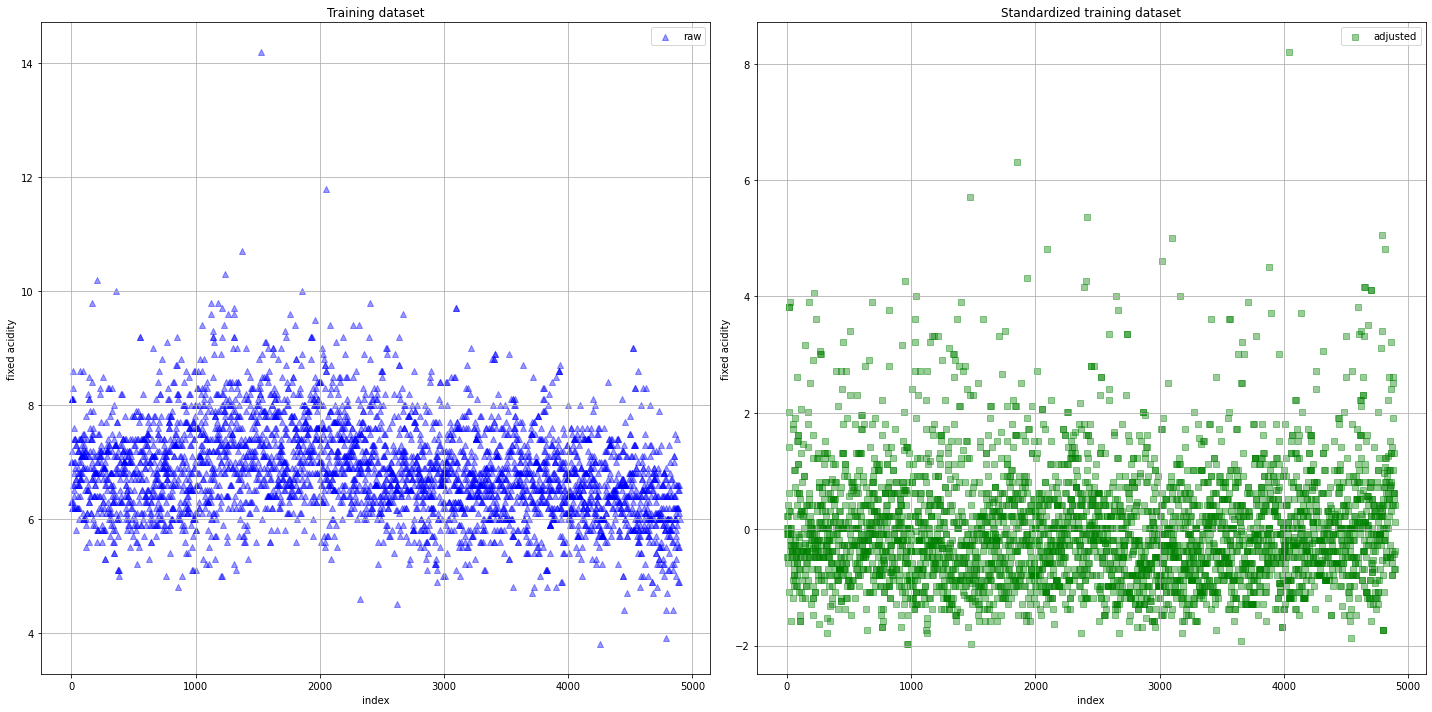

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

ax1.scatter(x_train.index,
                x_train['fixed acidity'],
                color= 'blue',
                label='raw',
                alpha=0.4,
                marker='^'
                )

ax2.scatter(x_train.index,
                x_train_new[: , 1],
                color = 'green',
                label='adjusted',
                alpha=0.4,
                marker='s'
                )

ax1.set_title('Training dataset')
ax2.set_title('Standardized training dataset')

for ax in (ax1, ax2):
    ax.set_xlabel('index')
    ax.set_ylabel('fixed acidity')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

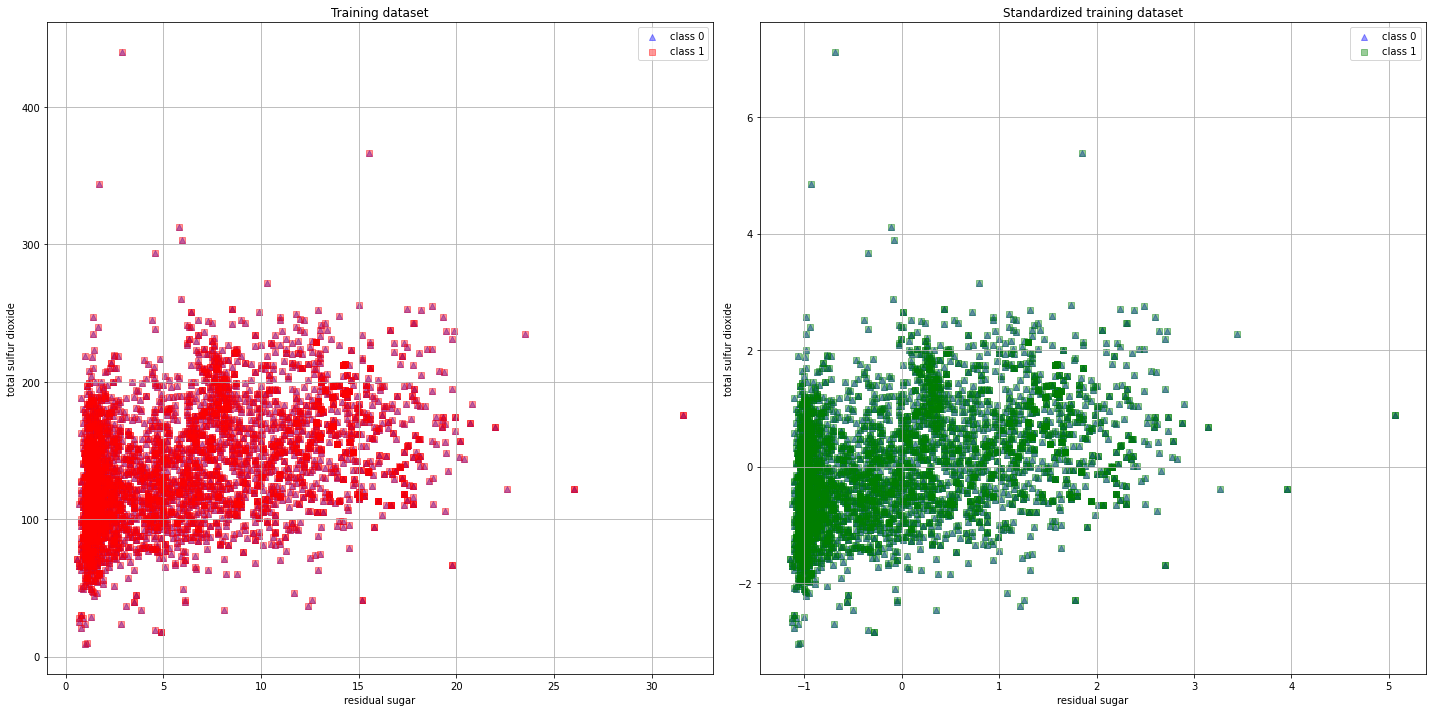

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

for l, c, m in zip(range(0, 2), ('blue', 'red'), ('^', 's')):
    ax1.scatter(x_train['residual sugar'],
                x_train['total sulfur dioxide'],
                color= c,
                label='class %s' % l,
                alpha=0.4,
                marker=m
                )

for l, c, m in zip(range(0, 2), ('blue', 'green'), ('^', 's')):
    ax2.scatter(x_train_new[: , 3],
                x_train_new[: , 6],
                color = c,
                label='class %s' % l,
                alpha=0.4,
                marker=m
                )

ax1.set_title('Training dataset')
ax2.set_title('Standardized training dataset')

for ax in (ax1, ax2):
    ax.set_xlabel('residual sugar')
    ax.set_ylabel('total sulfur dioxide')
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()

plt.show()

# Metrics visualization function

In [10]:
import matplotlib.pyplot as plt
epoch = 30 
def plot_learningCurve(history):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  #plotting the mae vs epoch of training set
  plt.plot(epoch_range, history.history['mae'])
  #plotting the val_mae vs epoch of the validation dataset.
  plt.plot(epoch_range, history.history['val_mae'])
  plt.ylim([0, 2])
  plt.title('Model mae')
  plt.ylabel('mae')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

  print("--------------------------------------------------------")

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.ylim([0, 4])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

# Small Model

In [11]:
small_model = tf.keras.Sequential([
                            tf.keras.layers.Dense(16 , 
                                                  activation = 'relu' , 
                                                  input_shape = (11 , )),
                            tf.keras.layers.Dense(1)
])
small_model.compile(optimizer = 'adam' , loss = 'mse' , metrics = ['mae'])
history_small = small_model.fit(x_train_new, y_train , 
                                batch_size = 32, 
                                epochs = 30, verbose = 0, 
                                validation_data = (x_val_new , y_val))

# Small Model Evaluation Metrics

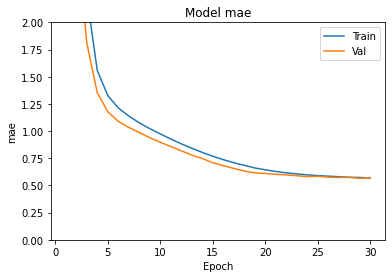

--------------------------------------------------------


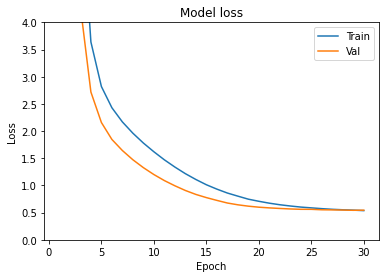

In [12]:
plot_learningCurve(history_small)

In [13]:
s_test_loss , s_test_mae = small_model.evaluate(x_test_new , y_test , batch_size=32 , verbose=1)
print("small model test_loss : {}".format(s_test_loss))
print("small model test_mae : {} ".format(s_test_mae))

23/23 [==============================] - 0s 2ms/step - loss: 0.6424 - mae: 0.6214
small model test_loss : 0.6424080729484558
small model test_mae : 0.6213688850402832 


In [14]:
import numpy as np
unseen_data = np.array([[6.0 , 0.28 , 0.22 , 12.15 , 0.048 , 42.0 , 163.0 , 0.99570 , 3.20 , 0.46 , 10.1]])

In [15]:
y_small = small_model.predict(sc_x.transform(unseen_data))
print ("Wine quality on unseen data (small model): ", y_small[0][0])

Wine quality on unseen data (small model):  5.560831


In [16]:
small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


# Medium Model

In [17]:
medium_model = tf.keras.Sequential([
                               tf.keras.layers.Dense(64 , activation = 'relu' , 
                                                     input_shape = (11, )),
                               tf.keras.layers.Dense(64 , activation = 'relu'),
                               tf.keras.layers.Dense(64 , activation = 'relu'),
                               tf.keras.layers.Dense(1)
])
medium_model.compile(loss = 'mse' , optimizer= 'adam' , metrics = ['mae'])
history_medium = medium_model.fit(x_train_new , y_train , batch_size=32, 
                                  epochs = 30, verbose = 0 , 
                                  validation_data= (x_val_new , y_val))

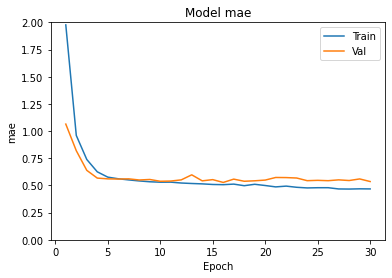

--------------------------------------------------------


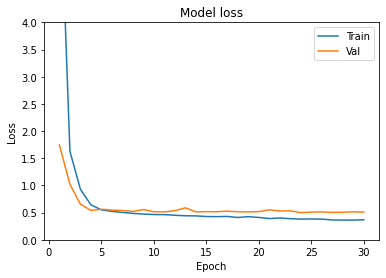

In [18]:
plot_learningCurve(history_medium)

In [19]:
m_test_loss , m_test_mae = medium_model.evaluate(x_test_new , y_test , batch_size=32 , verbose = 1)
print("medium model test_loss : {}".format(m_test_loss))
print("medium model test_mae : {}".format(m_test_mae))

23/23 [==============================] - 0s 2ms/step - loss: 0.6044 - mae: 0.5865
medium model test_loss : 0.6043699979782104
medium model test_mae : 0.5865082144737244


In [20]:
y_medium = medium_model.predict(sc_x.transform(unseen_data))
print ("Wine quality on unseen data (medium model): ", y_medium[0][0])

Wine quality on unseen data (medium model):  5.489296


In [21]:
medium_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________


# Large Model

In [22]:
large_model = tf.keras.Sequential([
                               tf.keras.layers.Dense(128 , activation = 'relu' , 
                                                     input_shape = (11, )),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dense(1)
])

large_model.compile(loss = 'mse' , optimizer= 'adam' , metrics = ['mae'])


history_large = large_model.fit(x_train_new , y_train , batch_size=32, epochs = 30,verbose = 0 , validation_data= (x_val_new , y_val))

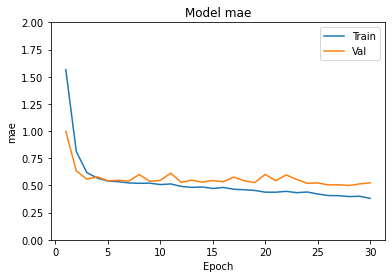

--------------------------------------------------------


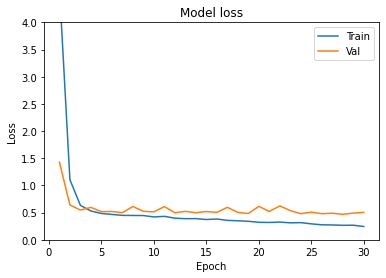

In [23]:
plot_learningCurve(history_large)

In [24]:
l_test_loss , l_test_mae = large_model.evaluate(x_test_new , y_test , batch_size = 32 , verbose = 1)
print("large model test_loss : {}".format(l_test_loss))
print("large model test_mae : {}".format(l_test_mae))

23/23 [==============================] - 0s 1ms/step - loss: 0.6016 - mae: 0.5509
large model test_loss : 0.601615846157074
large model test_mae : 0.5509471893310547


In [25]:
y_large = large_model.predict(sc_x.transform(np.array([[6.0 , 0.28 , 0.22 , 12.15 , 0.048 , 42.0 , 163.0 , 0.99570 , 3.20 , 0.46 , 10.1]])))
print ("Wine quality on unseen data (large model): ", y_large[0][0])

Wine quality on unseen data (large model):  5.2759633


In [26]:
large_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1536      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________


# Reducing Overfitting in case of Large Model

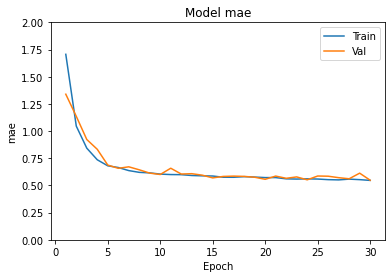

--------------------------------------------------------


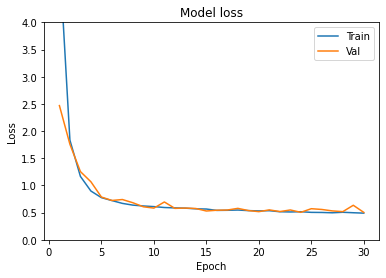

In [27]:
large_model_overfit = tf.keras.Sequential([
                               tf.keras.layers.Dense(128 , activation = 'relu' , 
                                                     input_shape = (11, )),
                               tf.keras.layers.Dropout(0.4),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dropout(0.3),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dropout(0.2),
                               tf.keras.layers.Dense(128 , activation = 'relu'),
                               tf.keras.layers.Dense(1)
])
large_model_overfit.compile(loss = 'mse' , optimizer= 'adam' , metrics = ['mae'])
history_large_overfit = large_model_overfit.fit(x_train_new , y_train , batch_size=32, epochs = 30,verbose = 0 , validation_data= (x_val_new , y_val))
plot_learningCurve(history_large_overfit)

# Training Optimization in case of Small Model

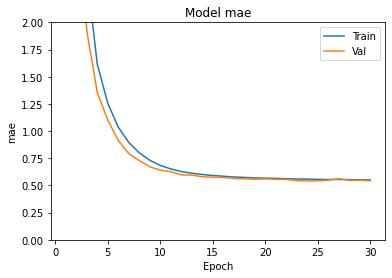

--------------------------------------------------------


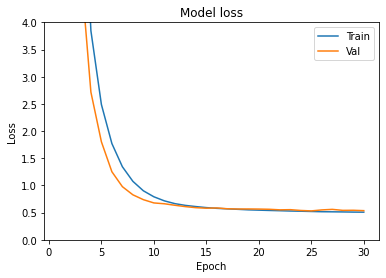

In [28]:
model_small = tf.keras.Sequential([
                tf.keras.layers.Dense(16 , 
                    activation = 'relu' , 
                    input_shape = (11 , )),              
              tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.RMSprop(0.001)
model_small.compile(loss = 'mse' , optimizer = optimizer , metrics = ['mae'])
history_small_overfit = model_small.fit(x_train_new , y_train , batch_size=32, 
                        epochs = 30, verbose = 0 , 
                        validation_data= (x_val_new , y_val))
plot_learningCurve(history_small_overfit)